In [878]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime, timedelta

In [879]:
df = pd.read_csv('bookings.csv', parse_dates=['date','start_time', 'end_time'], index_col=[0])
df.head()

,start_time,end_time,total_time_hours
date,,,
2021-02-23,2021-02-23 13:00:00,2021-02-23 16:00:00,3.0
2021-03-29,2021-03-29 10:00:00,2021-03-29 13:00:00,3.0
2021-04-22,2021-04-22 08:30:00,2021-04-22 11:30:00,3.0
2021-04-29,2021-04-29 11:30:00,2021-04-29 14:30:00,3.0
2021-05-15,2021-05-15 17:30:00,2021-05-15 19:00:00,1.5


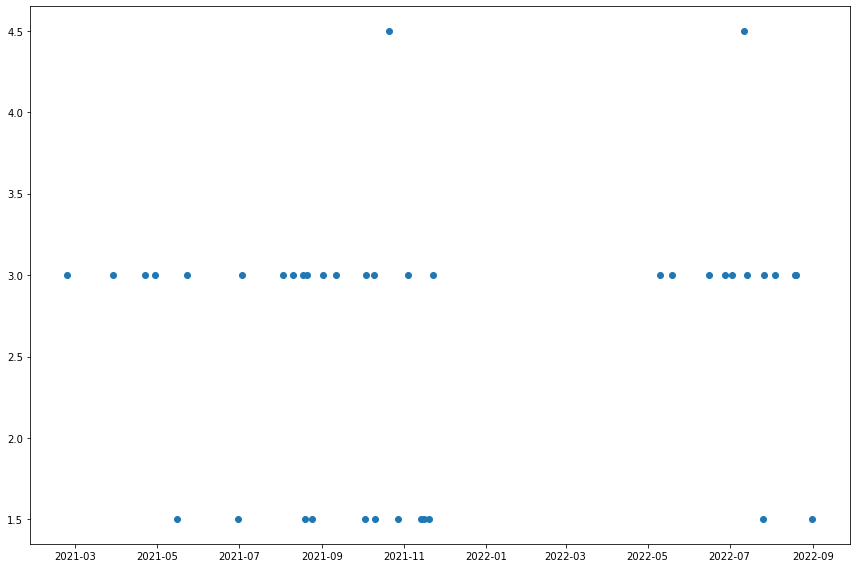

In [880]:
fig = plt.figure(figsize=(12, 8))

plt.scatter(df.start_time, df.total_time_hours)
plt.tight_layout()
plt.show()

In [881]:
df = df.drop(['start_time', 'end_time'], axis=1)
df.head()

,total_time_hours
date,
2021-02-23,3.0
2021-03-29,3.0
2021-04-22,3.0
2021-04-29,3.0
2021-05-15,1.5


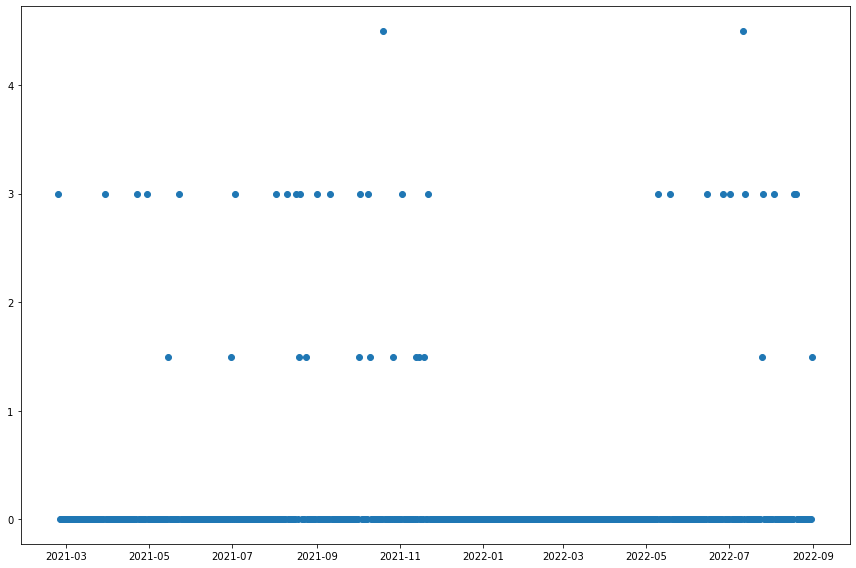

In [882]:
df = df.resample('D').mean().replace(np.nan, 0)
fig = plt.figure(figsize=(12, 8))

plt.scatter(df.index, df)
plt.tight_layout()
plt.show()

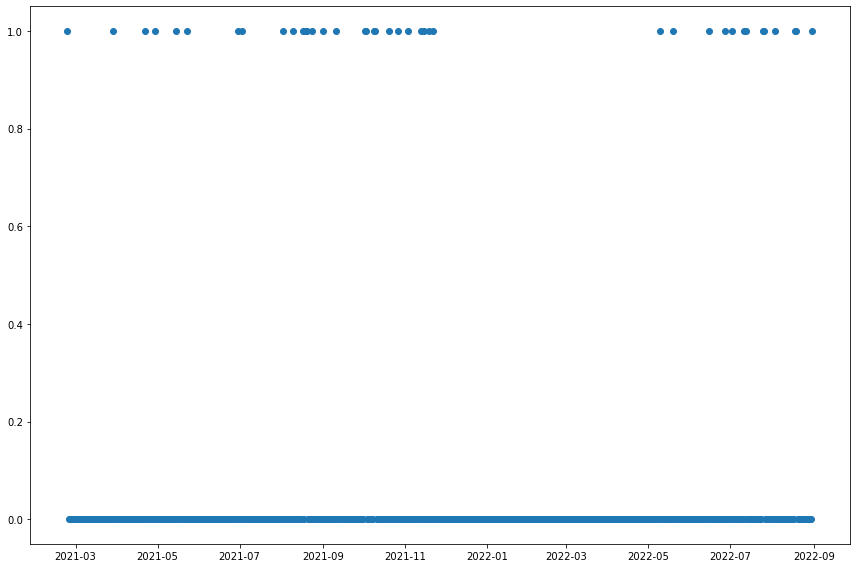

In [883]:
df_binary = df.copy()
df_binary[df_binary > 0] = 1
df_binary.rename(columns={'total_time_hours': 'booked'}, inplace=True)
fig = plt.figure(figsize=(12, 8))

plt.scatter(df_binary.index, df_binary)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

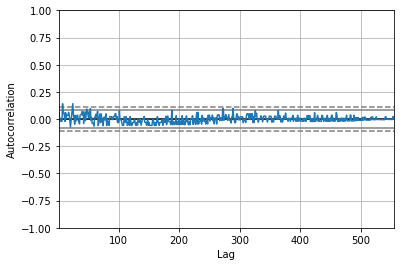

In [884]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_binary['booked'])

In [885]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_binary.booked.to_numpy(), order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  555
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -80.531
Date:                Fri, 02 Sep 2022   AIC                            173.061
Time:                        10:13:46   BIC                            198.964
Sample:                             0   HQIC                           183.180
                                - 555                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7607      0.032    -23.942      0.000      -0.823      -0.698
ar.L2         -0.5969      0.042    -14.339      0.000      -0.678      -0.515
ar.L3         -0.4322      0.046     -9.338      0.0

In [886]:
forecast = model_fit.forecast(steps=31)
forecast

array([0.23933962, 0.22107751, 0.25677103, 0.2722362 , 0.31826054,
       0.38173427, 0.29152114, 0.29224751, 0.30204136, 0.30717175,
       0.31408462, 0.31527623, 0.30500469, 0.30607918, 0.30803015,
       0.3089205 , 0.30948112, 0.30895042, 0.30788885, 0.3082044 ,
       0.30852304, 0.30862203, 0.30861763, 0.30849472, 0.30840457,
       0.30846969, 0.30851308, 0.30851736, 0.30850586, 0.30848791,
       0.30848361])

In [887]:
df_binary.iloc[-1]

booked    1.0
Name: 2022-08-31 00:00:00, dtype: float64

In [888]:
dates_forward = [{'date': datetime.today() + timedelta(days=i), 'booked': forecast[i-1]} for i in range(1, len(forecast))]
print(f"Most likely day to to book laundry slot: {dates_forward[np.argmax(forecast)]['date'].date()} ")

Most likely day to to book laundry slot: 2022-09-08 


In [889]:
preds = pd.DataFrame.from_dict(dates_forward).set_index('date')

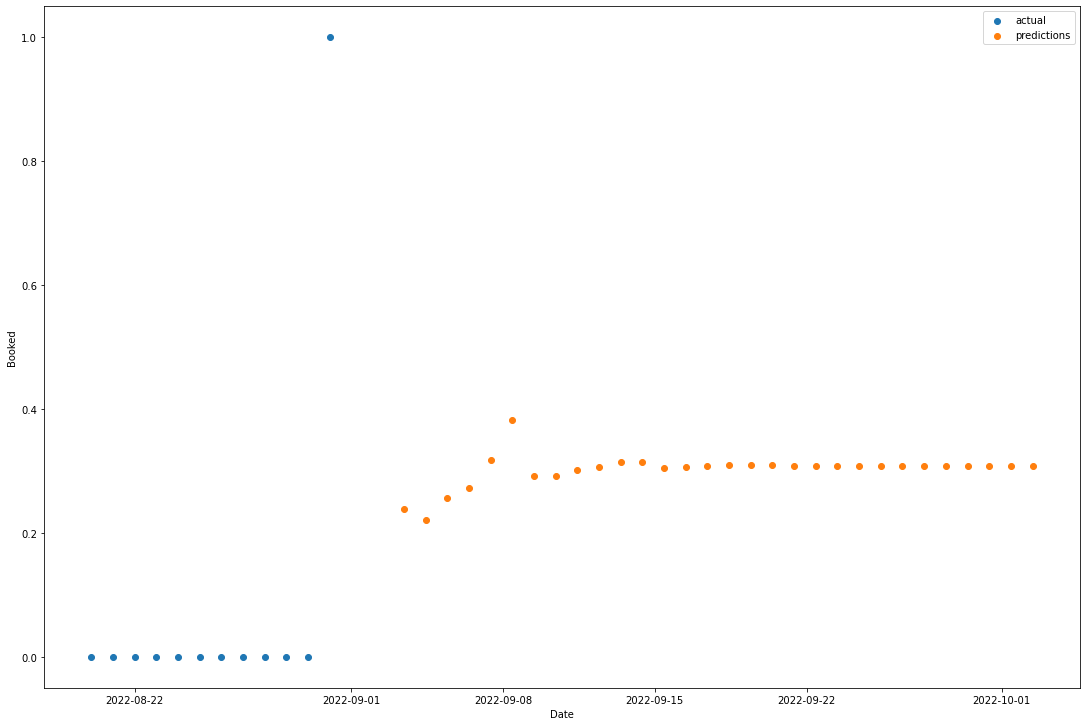

In [890]:
from datetime import date


fig = plt.figure(figsize=(15, 10))

smaller_window = df_binary.index > datetime.today() - timedelta(days=14)

plt.scatter(df_binary[smaller_window].index, df_binary[smaller_window], label='actual')
plt.scatter(preds.index, preds, label='predictions')
plt.tight_layout()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Booked')
plt.show()

In [891]:
from sklearn.linear_model import LogisticRegression

In [892]:
df_rolling = pd.read_csv('bookings.csv', parse_dates=['date','start_time', 'end_time'], index_col=[0])
df_rolling = df_rolling.drop(['start_time', 'end_time'], axis=1)
df_rolling[df_rolling > 0] = 1
df_rolling.head()

,total_time_hours
date,
2021-02-23,1.0
2021-03-29,1.0
2021-04-22,1.0
2021-04-29,1.0
2021-05-15,1.0


In [893]:
df_rolling = df_rolling.reset_index()
df_rolling['days_since_booked'] = (df_rolling.date - np.roll(df_rolling.date, shift=1))
df_rolling.days_since_booked = df_rolling.days_since_booked.apply(lambda x: x.days)
df_rolling.rename(columns={'total_time_hours': 'booked'}, inplace=True)
# drop first row
df_rolling = df_rolling.drop(df_rolling.index[0])
df_rolling.head()


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,booked,days_since_booked
1,2021-03-29,1.0,34
2,2021-04-22,1.0,24
3,2021-04-29,1.0,7
4,2021-05-15,1.0,16
5,2021-05-23,1.0,8


In [894]:
df_rolling_filled_dates = df_rolling.set_index('date').resample('D').mean()
# increment by 1 each day until the next booking    
for idx, row in df_rolling_filled_dates.iterrows():
    if row.booked == 1:
        counter = 1
    else:
        row.days_since_booked = counter
        counter += 1
df_rolling_filled_dates.replace(np.nan, 0, inplace=True)
df_rolling_filled_dates.head(0)

,booked,days_since_booked
date,,


In [901]:
lr = LogisticRegression(class_weight='balanced')
# Use only data after 2022-05-11
df_rolling_filled_dates = df_rolling_filled_dates[df_rolling_filled_dates.index > datetime(2022, 5, 11)]
X, y = df_rolling_filled_dates.days_since_booked.values.reshape(-1, 1), df_rolling_filled_dates.booked.values.ravel()
# split 
N = len(X)
print(N)
X_train, X_test, y_train, y_test = X[:int(N*0.8)], X[int(N*0.8):], y[:int(N*0.8)], y[int(N*0.8):]
print('Length of training set: ', len(X_train))
print('Length of test set: ', len(X_test))
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

112
Length of training set:  89
Length of test set:  23


0.5652173913043478

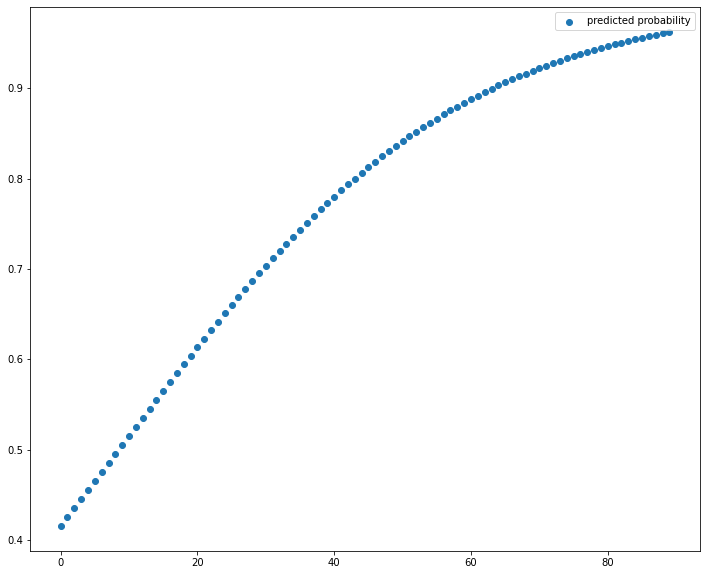

In [903]:
vals = np.arange(0, 90).reshape(-1, 1)
plt.figure(figsize=(12, 10))
plt.scatter(vals, lr.predict_proba(vals)[:, 1], label='predicted probability')
#plt.scatter(vals[y_test==1], y_test[y_test==1], label='actual')
plt.legend()
plt.show()


In [897]:
# get date from the last row of df_rolling_filled_dates
latest_booking_date = df_rolling_filled_dates.index[-1].date()

if latest_booking_date > date.today():
    print('Laundry slot already booked in the future. No need to compute probability.')

dates_forward = [latest_booking_date + timedelta(days=i) for i in range(0, 30)]


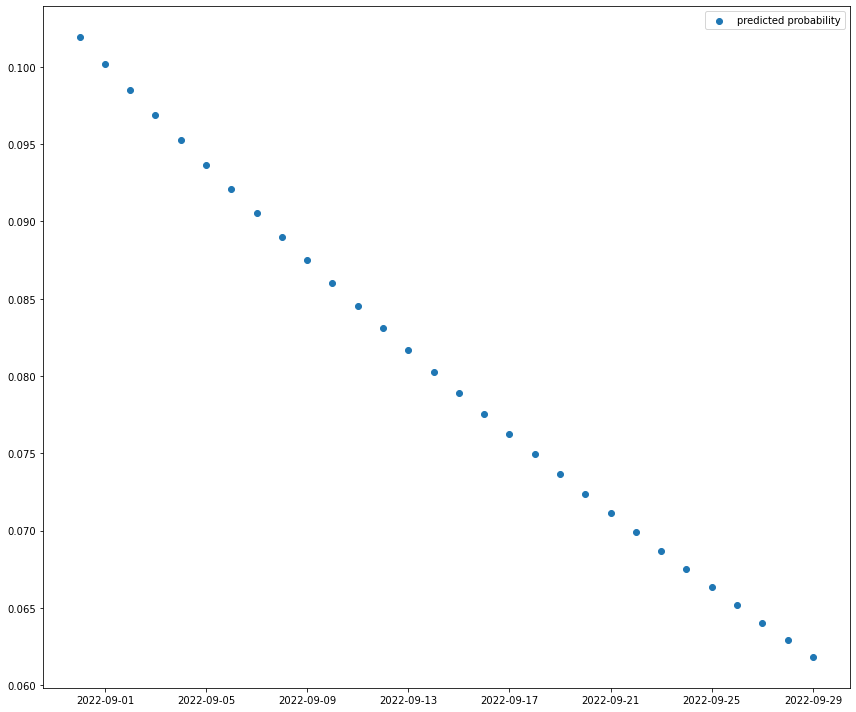

In [898]:
vals = np.arange(0, 30).reshape(-1, 1)
plt.figure(figsize=(12, 10))
plt.scatter(dates_forward, lr.predict_proba(vals)[:, 1], label='predicted probability')
#plt.scatter(vals[y_test==1], y_test[y_test==1], label='actual')
plt.legend()
plt.tight_layout()
plt.savefig('current_predictions.png' ,dpi=150, bbox_inches = "tight")
plt.show()
